# Convolutional Neural Networks (LeNet)

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## LeNet

At a very high level, LeNet consists of two components:
1. Convolutional layers, of which there are two
2. Dense, fully connected layers, eventually leading to 10 outputs for digit recognicition.

In each convolutional block, there's a convolutional layer, a sigmoid activation, and an average pooling. Note: ReLU activation an max-pooling actually work better, but had not yet been invented. Each convolutional layer uses a 5x5 kernel. Typically, these increase the number of channels, with the first having an output of 6 channels, and the second 16, while reducing the spatial resolution b a factor of 4. 

The outputs of the final convolutional block are flattened, so that there can be a fully-connected block with 120, 84 and 10 outputs. "

In [13]:
def init_cnn(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels = 6, kernel_size = 5, padding = 2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(out_channels = 16, kernel_size = 5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.Sigmoid(),
            nn.LazyLinear(84),
            nn.Sigmoid(),
            nn.LazyLinear(num_classes)
        )

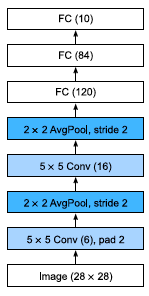

In [14]:
@d2l.add_to_class(d2l.Classifier)

def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [15]:
model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


Height and width reduced layer over layer. Second convolutional layer does not include padding, so height and width reduced by four pixels. 

## Training

In [ ]:
trainer = d2l.Trainer(max_epoch=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(